In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [28]:
path="drive/My Drive/Project"

In [29]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

In [30]:
target_size = (32,32)
dataset = ImageFolder(path, transform = transforms.Compose([
    transforms.Resize(target_size),  # Resize the image
    transforms.ToTensor(),transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean = (0.1307,), std = (0.3081,))]))

In [31]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([1, 32, 32]) 0


tensor([[[2.0575, 2.0448, 2.0575,  ..., 2.0448, 2.0575, 2.0575],
         [2.0575, 2.0448, 2.0830,  ..., 2.0575, 2.0448, 2.0448],
         [2.0703, 2.1848, 2.2866,  ..., 2.2357, 2.0703, 2.0448],
         ...,
         [2.5539, 2.6939, 2.6303,  ..., 2.4903, 2.4012, 2.3884],
         [2.1466, 2.2994, 2.4139,  ..., 2.4648, 2.3884, 2.4012],
         [2.3884, 2.4266, 2.4394,  ..., 2.6430, 2.5666, 2.5539]]])

In [32]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [33]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  COVID (0)


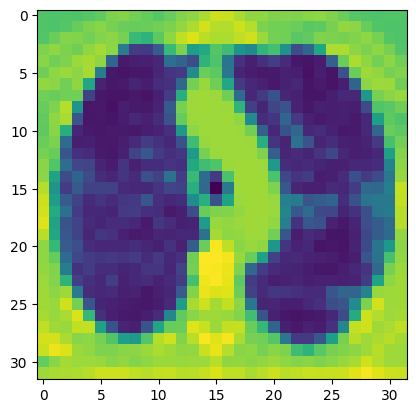

In [34]:
show_example(*dataset[0])

Label:  COVID (0)


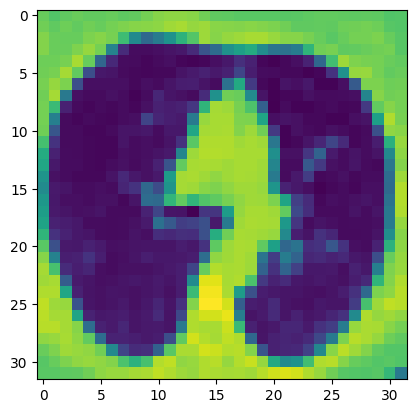

In [35]:
show_example(*dataset[1099])

In [36]:
import torch
import torchvision
from torch.utils.data import random_split

In [37]:
random_seed = 42
torch.manual_seed(random_seed);

In [38]:
val_size = 700
test_size= 300
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(1507, 700, 300)

In [39]:
from torch.utils.data.dataloader import DataLoader

batch_size=32

In [40]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2,shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2,shuffle=True, num_workers=2, pin_memory=True)

In [41]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

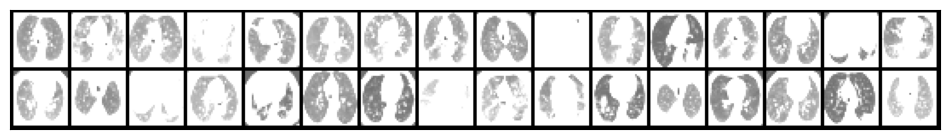

In [ ]:
show_batch(train_dl)

In [43]:
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(ImageClassificationBase):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        # Fully connected layers
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # 10 classes for MNIST

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Flatten the output from convolutional layers
        x = x.view(-1, 16*5*5)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [46]:
model = LeNet()
model
# from torchsummary import summary
# summary(model, input_size=(3,32,32))

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [47]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 1, 32, 32])
out.shape: torch.Size([32, 2])
out[0]: tensor([ 0.1455, -0.0898], grad_fn=<SelectBackward0>)


In [48]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [49]:
evaluate(model, val_dl)

{'val_loss': 0.7016318440437317, 'val_acc': 0.4887310266494751}

In [52]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.0001

In [53]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6739, val_loss: 0.6715, val_acc: 0.5039
Epoch [1], train_loss: 0.6463, val_loss: 0.6494, val_acc: 0.6056
Epoch [2], train_loss: 0.6221, val_loss: 0.6451, val_acc: 0.5973
Epoch [3], train_loss: 0.5903, val_loss: 0.5961, val_acc: 0.6975
Epoch [4], train_loss: 0.5686, val_loss: 0.5885, val_acc: 0.6973
Epoch [5], train_loss: 0.5529, val_loss: 0.5808, val_acc: 0.7043
Epoch [6], train_loss: 0.5453, val_loss: 0.5732, val_acc: 0.7019
Epoch [7], train_loss: 0.5426, val_loss: 0.5701, val_acc: 0.7152
Epoch [8], train_loss: 0.5334, val_loss: 0.5735, val_acc: 0.6925
Epoch [9], train_loss: 0.5355, val_loss: 0.5731, val_acc: 0.7057
Epoch [10], train_loss: 0.5291, val_loss: 0.5614, val_acc: 0.7131
Epoch [11], train_loss: 0.5231, val_loss: 0.5588, val_acc: 0.7082
Epoch [12], train_loss: 0.5079, val_loss: 0.5559, val_acc: 0.7179
Epoch [13], train_loss: 0.5166, val_loss: 0.5600, val_acc: 0.7098
Epoch [14], train_loss: 0.5081, val_loss: 0.5533, val_acc: 0.7131
Epoch [15], train_lo

In [54]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

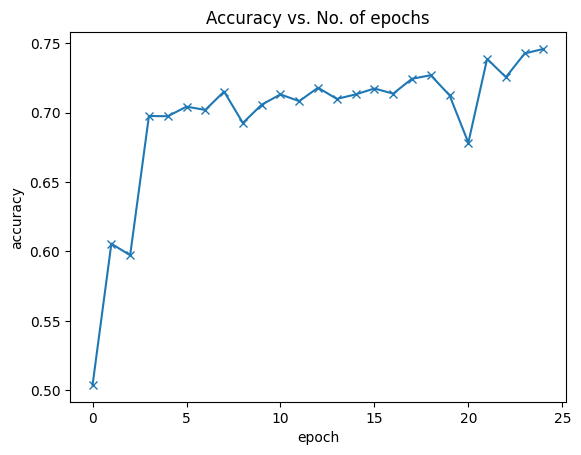

In [55]:
plot_accuracies(history)

In [56]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

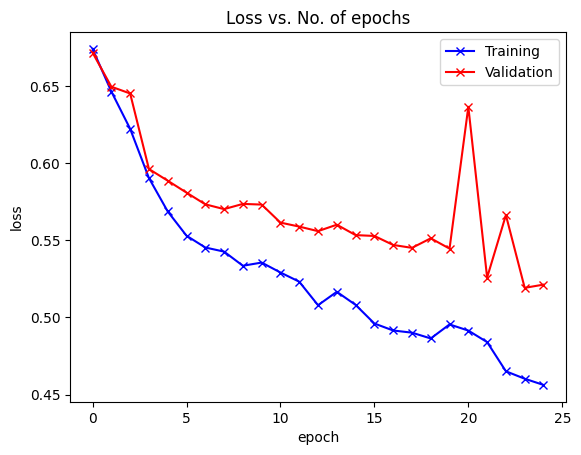

In [57]:
plot_losses(history)

In [67]:
evaluate(model,test_dl)

{'val_loss': 0.45945316553115845, 'val_acc': 0.7775567770004272}

In [58]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: COVID , Predicted: COVID


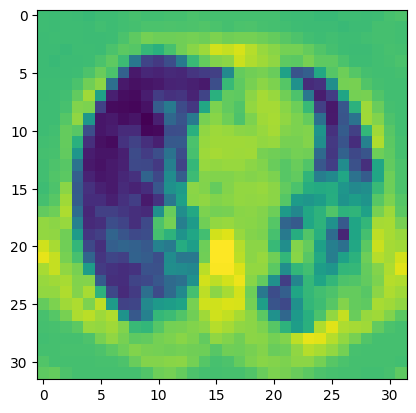

In [59]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: non-COVID , Predicted: non-COVID


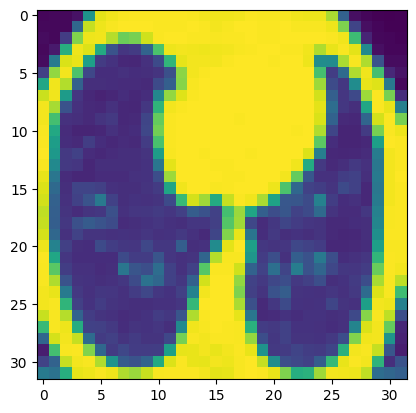

In [60]:
img, label = test_ds[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: COVID , Predicted: COVID


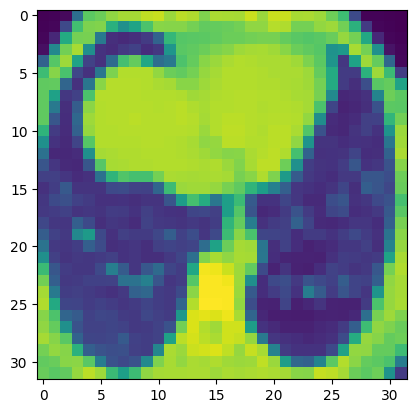

In [61]:
img, label = test_ds[150]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [62]:
import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have your validation data (X_val_tensor, y_val_tensor)
# Convert X_val_tensor to numpy array for easier handling
test_label=[]
for img,label in test_ds:
  test_label.append(label)
y_val=np.array(test_label)
y_val
# Predict classes for validation data

# with torch.no_grad():
#     outputs = model(test_ds)
#     predicted_labels = torch.argmax(outputs, dim=1).numpy()



array([0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1])

In [63]:
model.eval()
predicted_labels = []

# Iterate through all the test images
for img,label1 in test_ds:
    # Predict the label for the current image
    label = predict_image(img, model)
    if(label=='COVID'):
      predicted_labels.append(0)
    else:
      predicted_labels.append(1)
    # Append the predicted label to the list
    # predicted_labels.append(label)

# Convert the list of predicted labels to a numpy array
predicted_labels_array = np.array(predicted_labels)

predicted_labels_array

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1])

Precision: 0.7647058823529411
Recall: 0.785234899328859


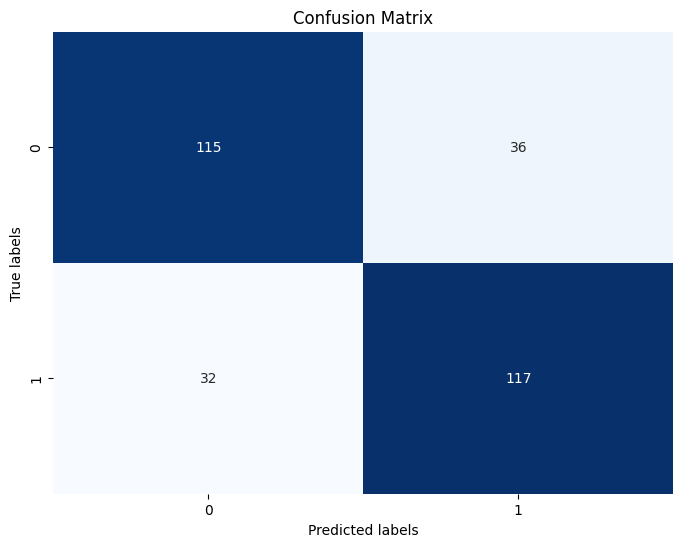

In [64]:
# Calculate precision and recall
precision = precision_score(y_val, predicted_labels_array)
recall = recall_score(y_val, predicted_labels_array)
print("Precision:", precision)
print("Recall:", recall)

# Plot confusion matrix
cm = confusion_matrix(y_val, predicted_labels_array)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [65]:
torch.save(model.state_dict(), '/content/drive/My Drive/simple_nnlenet_model.pth')

In [66]:
# import torch
# from torch.utils.data import Dataset
# from torchvision import transforms
# from PIL import Image

# class SingleChannelDataset(Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset  # Original dataset containing three-channel images
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         # Load the original three-channel image tensor
#         image_tensor, label = self.dataset[idx]
#         # Convert the tensor to a PIL image
#         image = transforms.ToPILImage()(image_tensor)
#         # Convert the image to grayscale
#         image = image.convert('L')
#         # Convert the grayscale image back to a tensor
#         image_tensor = transforms.ToTensor()(image)
#         # Apply any additional transformations
#         if self.transform:
#             image_tensor = self.transform(image_tensor)
#         return image_tensor, label

# # Example usage:
# # Assuming you have an existing dataset (e.g., torchvision.datasets.ImageFolder)
# # and you want to convert it to a single-channel dataset

# # Define transformations (if any)
# transform = transforms.Compose([
#     transforms.Resize((32, 32)),  # Resize the image
#     transforms.ToTensor(),
#     transforms.Normalize(mean = (0.1307,), std = (0.3081,))# Convert PIL image to PyTorch tensor
# ])

# # Create the original dataset (e.g., torchvision.datasets.ImageFolder)
# # Replace 'root' and 'transform' with your actual dataset root directory and transformations
# original_dataset = ImageFolder(root=path,transform=transform)

# # Create the single-channel dataset
# dataset = SingleChannelDataset(original_dataset)

# # Accessing a single sample from the single-channel dataset
# sample_image, sample_label = dataset[0]
